# Outlier Detection Benchmarks (Simplified, pymoo-based)

Uses `pymoo` to define benchmarks (Branin, Rosenbrock, Hartmann3, Kursawe).
- DoE (random or LHS)
- Outlier injection on y
- Detectors: IQR(y), IsolationForest, LOF, One-Class SVM, Robust Covariance
- Gaussian Process residual diagnostics and pre-simulation risk

Multi-objective problems are reduced to `y = F[:, 0]`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from pymoo.problems import get_problem
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
try:
    from scipy.stats import chi2
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False


In [2]:
def lhs(bounds: np.ndarray, n: int, rng=None) -> np.ndarray:
    rng = np.random.default_rng() if rng is None else rng
    d = bounds.shape[0]
    X = np.zeros((n, d))
    for j in range(d):
        perm = rng.permutation(n)
        pts = (perm + rng.random(n)) / n
        low, high = bounds[j, 0], bounds[j, 1]
        X[:, j] = low + pts * (high - low)
    return X

def sample_uniform(bounds: np.ndarray, n: int, rng=None) -> np.ndarray:
    rng = np.random.default_rng() if rng is None else rng
    low, high = bounds[:, 0], bounds[:, 1]
    u = rng.random((n, bounds.shape[0]))
    return low + u * (high - low)


In [3]:
def get_bounds_from_problem(problem) -> np.ndarray:
    return np.column_stack([problem.xl, problem.xu])

def generate_dataset(problem_name: str, n: int, sampler: str = "lhs", rng=None) -> Tuple[np.ndarray, np.ndarray, object]:
    rng = np.random.default_rng() if rng is None else rng
    problem = get_problem(problem_name)
    bounds = get_bounds_from_problem(problem)
    if sampler == "lhs":
        X = lhs(bounds, n, rng)
    elif sampler == "random":
        X = sample_uniform(bounds, n, rng)
    else:
        raise ValueError("sampler must be 'lhs' or 'random'")
    F = problem.evaluate(X)
    y = F[:, 0] if F.ndim == 2 else F
    y = np.asarray(y).ravel()
    return X, y, problem


In [4]:
def add_outliers_y(y: np.ndarray, frac_y: float = 0.05, scale: float = 5.0, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    n = y.shape[0]
    mask = np.zeros(n, dtype=bool)
    k = int(np.round(frac_y * n))
    y_out = y.copy()
    if k > 0:
        idx = rng.choice(n, size=k, replace=False)
        mask[idx] = True
        sigma = np.std(y) + 1e-9
        y_out[idx] = y_out[idx] + rng.standard_normal(k) * (scale * sigma)
    return y_out, mask


In [5]:
def detect_iqr(y: np.ndarray, k: float = 1.5) -> np.ndarray:
    q1, q3 = np.percentile(y, 25), np.percentile(y, 75)
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return (y < lower) | (y > upper)

def detect_isoforest(X: np.ndarray, contamination: float = 0.05, random_state: int = 42):
    clf = IsolationForest(contamination=contamination, random_state=random_state)
    pred = clf.fit_predict(X)
    return pred == -1, clf

def detect_lof(X: np.ndarray, contamination: float = 0.05, n_neighbors: int = 20):
    lof = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
    pred = lof.fit_predict(X)
    return pred == -1, lof

def detect_ocsvm(X: np.ndarray, nu: float = 0.05, gamma = "scale"):
    oc = OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
    pred = oc.fit_predict(X)
    return pred == -1, oc

def detect_robust_cov(X: np.ndarray, contamination: float = 0.05):
    ee = EllipticEnvelope(contamination=contamination, support_fraction=1.0, random_state=42)
    pred = ee.fit_predict(X)
    return pred == -1, ee


In [6]:
def fit_gp(X: np.ndarray, y: np.ndarray) -> GaussianProcessRegressor:
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-2, 1e3)) \
             + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-9, 1e-1))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, normalize_y=True, random_state=42)
    gp.fit(X, y)
    return gp

def residual_diagnostics(gp: GaussianProcessRegressor, X: np.ndarray, y: np.ndarray):
    y_pred, y_std = gp.predict(X, return_std=True)
    resid = y - y_pred
    sigma_resid = np.std(resid)
    return y_pred, y_std, resid, sigma_resid

def mahalanobis_d2(X: np.ndarray):
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False) + 1e-9 * np.eye(X.shape[1])
    inv = np.linalg.inv(cov)
    dif = X - mu
    d2 = np.einsum('ni,ij,nj', dif, inv, dif)
    return d2

def risk_before_simulation(X_train: np.ndarray, X_eval: np.ndarray, gp: GaussianProcessRegressor = None):
    d2 = mahalanobis_d2(np.vstack([X_train, X_eval]))[-X_eval.shape[0]:]
    risk = { 'mahalanobis_d2': d2 }
    if SCIPY_AVAILABLE:
        risk['mahalanobis_p'] = 1.0 - chi2.cdf(d2, df=X_train.shape[1])
    if gp is not None:
        _, std = gp.predict(X_eval, return_std=True)
        risk['gp_sigma'] = std
    return risk


In [7]:
def plot_scatter_2d(X: np.ndarray, y: np.ndarray, mask_outliers=None, title='2D scatter (color=y)'):
    if X.shape[1] != 2:
        raise ValueError('plot_scatter_2d requires 2D inputs.')
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(X[:, 0], X[:, 1], s=30, c=y)
    plt.xlabel('x1'); plt.ylabel('x2'); plt.title(title)
    plt.colorbar(sc, label='y')
    if mask_outliers is not None:
        idx = np.where(mask_outliers)[0]
        plt.scatter(X[idx, 0], X[idx, 1], s=80, facecolors='none', edgecolors='k')
    plt.tight_layout(); plt.show()

def plot_residuals(y_true, y_pred, sigma_resid, k=2.0, title='Residuals vs Predicted (±kσ)'):
    resid = y_true - y_pred
    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, resid, s=25)
    plt.axhline(0.0)
    plt.axhline(+k * sigma_resid, linestyle='--')
    plt.axhline(-k * sigma_resid, linestyle='--')
    plt.xlabel('Predicted'); plt.ylabel('Residual')
    plt.title(title)
    plt.tight_layout(); plt.show()

def plot_isoforest_scores(clf: IsolationForest, X_fit: np.ndarray):
    # FIX: pass the training or evaluation X explicitly; do not use private attributes
    scores = clf.score_samples(X_fit)
    plt.figure(figsize=(6, 4))
    plt.hist(scores, bins=30)
    plt.xlabel('IsolationForest score'); plt.ylabel('Count')
    plt.title('Distribution of IsolationForest scores')
    plt.tight_layout(); plt.show()

def plot_gp_variance_2d(gp: GaussianProcessRegressor, bounds: np.ndarray, grid_n: int = 80, title='GP predictive std'):
    if bounds.shape[0] != 2:
        raise ValueError('plot_gp_variance_2d requires 2D bounds.')
    x1 = np.linspace(bounds[0, 0], bounds[0, 1], grid_n)
    x2 = np.linspace(bounds[1, 0], bounds[1, 1], grid_n)
    X1, X2 = np.meshgrid(x1, x2)
    Xg = np.column_stack([X1.ravel(), X2.ravel()])
    _, std = gp.predict(Xg, return_std=True)
    Z = std.reshape(X1.shape)
    plt.figure(figsize=(6, 5))
    cs = plt.contourf(X1, X2, Z, levels=20)
    plt.colorbar(cs, label='Pred. std (σ)')
    plt.xlabel('x1'); plt.ylabel('x2'); plt.title(title)
    plt.tight_layout(); plt.show()


## Demo
Set `PROBLEM_NAME`, `N`, `SAMPLER`, and `FRAC_Y`.

Injected outliers: 20 / 200
Detection summary (vs injected ground truth):
IQR(y)              flagged=  7 | TP=  7  FP=  0  FN= 13
IsolationForest     flagged= 20 | TP=  2  FP= 18  FN= 18
LOF                 flagged= 20 | TP=  2  FP= 18  FN= 18
One-Class SVM       flagged= 20 | TP=  4  FP= 16  FN= 16
Robust Covariance   flagged= 20 | TP=  1  FP= 19  FN= 19
GP R^2 on all points: 0.892, residual σ=1.2


c:\Users\jkadaba\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


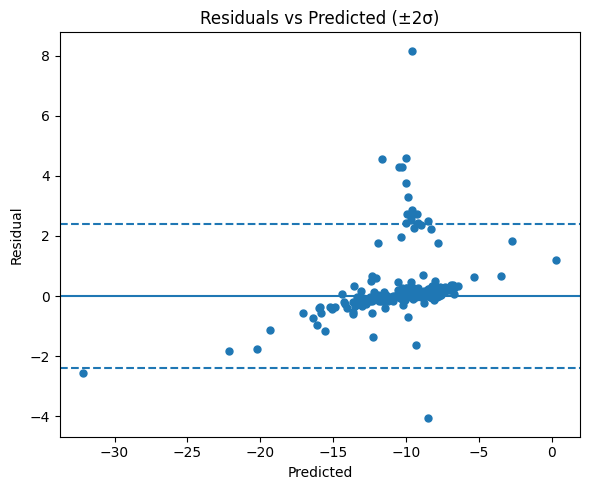

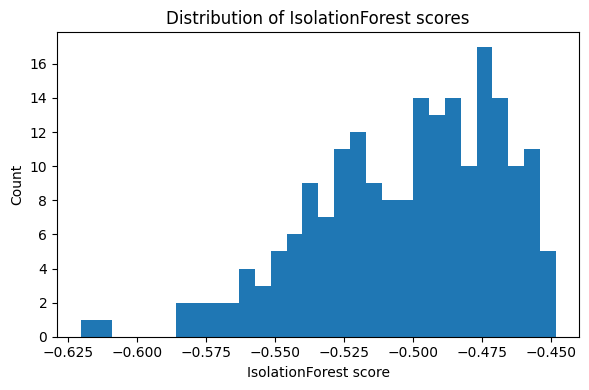

In [14]:
# Parameters
PROBLEM_NAME = 'kursawe'   # 'rosenbrock' | 'kursawe'
N = 200
SAMPLER = 'lhs'            # 'lhs' or 'random'
FRAC_Y = 0.10              # fraction of response-space outliers

# 1) Generate dataset
X, y, problem = generate_dataset(PROBLEM_NAME, N, SAMPLER)

# 2) Inject outliers (response only)
y_noisy, mask_injected = add_outliers_y(y, frac_y=FRAC_Y, scale=5.0)

print(f"Injected outliers: {mask_injected.sum()} / {N}")

# 3) Run detectors
mask_iqr = detect_iqr(y_noisy, k=1.5)
mask_iso, clf_iso = detect_isoforest(X, contamination=max(0.01, FRAC_Y))
mask_lof, lof = detect_lof(X, contamination=max(0.01, FRAC_Y))
mask_oc, oc = detect_ocsvm(X, nu=max(0.01, FRAC_Y))
mask_rc, ee = detect_robust_cov(X, contamination=max(0.01, FRAC_Y))

def report(name, mask):
    tp = np.sum(mask & mask_injected)
    fp = np.sum(mask & ~mask_injected)
    fn = np.sum(~mask & mask_injected)
    print(f"{name:18s}  flagged={mask.sum():3d} | TP={tp:3d}  FP={fp:3d}  FN={fn:3d}")

print('Detection summary (vs injected ground truth):')
report('IQR(y)', mask_iqr)
report('IsolationForest', mask_iso)
report('LOF', mask_lof)
report('One-Class SVM', mask_oc)
report('Robust Covariance', mask_rc)

# 4) GP residual diagnostics (fit on IF-inliers)
gp = fit_gp(X[~mask_iso], y_noisy[~mask_iso])
y_pred, y_std, resid, sigma_resid = residual_diagnostics(gp, X, y_noisy)

from sklearn.metrics import r2_score
print(f"GP R^2 on all points: {r2_score(y_noisy, y_pred):.3f}, residual σ={sigma_resid:.3g}")

# 5) Plots (each in its own figure)
if X.shape[1] == 2:
    bounds = np.column_stack([problem.xl, problem.xu])
    plot_scatter_2d(X, y_noisy, mask_outliers=mask_injected, title=f"{PROBLEM_NAME}: DoE with injected outliers")
    plot_gp_variance_2d(gp, bounds, grid_n=80, title="GP predictive std (pre-sim risk proxy)")

plot_residuals(y_noisy, y_pred, sigma_resid, k=2.0, title='Residuals vs Predicted (±2σ)')
plot_isoforest_scores(clf_iso, X_fit=X)
